In [1]:
import numpy as np
import torch
from data.dataset import DatasetLoader, OneDDatasetLoader, OneDDatasetBuilder
import matplotlib.pyplot as plt

In [2]:
# Loading raw dataset
dataset = OneDDatasetLoader(
    root_dir='/data1/tam/downloaded_datasets_transformed'
)

In [ ]:
# Batching dataset
# batched_dataset = dataset.batching(batch_size=5000, batch_n_times=10, recursive=True,
#                                     sub_dir='/batched/')
# batched_dataset = OneDDatasetLoader(
#     root_dir='/data1/tam/downloaded_datasets_transformed',
#     sub_dir='/batched/'
# )

In [3]:
# Transforming/scaling dataset
p_min = dataset.min(var_name='pressure', axis=None).numpy()
p_max = dataset.max(var_name='pressure', axis=None).numpy()
print(p_min, p_max)
q_min = dataset.min(var_name='flowrate', axis=None).numpy()
q_max = dataset.max(var_name='flowrate', axis=None).numpy()
print(q_min, q_max)
u_min = dataset.min(var_name='velocity', axis=None).numpy()
u_max = dataset.max(var_name='velocity', axis=None).numpy()
print(u_min, u_max)

ea_min = dataset.min(var_name='edge_attr', axis=0).numpy()
ea_max = dataset.max(var_name='edge_attr', axis=0).numpy()
vol0_min = ea_min[-2]
vol1_min = ea_min[-1]
vol0_max = ea_max[-2]
vol1_max = ea_max[-1]
ea_min[-2] = min(vol0_min, vol1_min)
ea_min[-1] = min(vol0_min, vol1_min)
ea_max[-2] = max(vol0_max, vol1_max)
ea_max[-1] = max(vol0_max, vol1_max)
print(ea_min, ea_max)


# p_mean = dataset.mean(var_name='pressure', axis=None).numpy()
# p_std = dataset.std(var_name='pressure', axis=None).numpy()
# print(p_mean, p_std)
# q_mean = dataset.mean(var_name='flowrate', axis=None).numpy()
# q_std = dataset.std(var_name='flowrate', axis=None).numpy()
# print(q_mean, q_std)
# u_mean = dataset.mean(var_name='velocity', axis=None).numpy()
# u_std = dataset.std(var_name='velocity', axis=None).numpy()
# print(u_mean, u_std)

-1512.088 518.5069
-0.0007853982 0.0007853982
-1.8074648e-05 1.7163045e-05
[0.01475028 0.4581773  0.         0.         0.         0.
 0.        ] [153.9461   25.57864  30.        5.        4.      182.1354  182.1354 ]


In [ ]:
# Ploting pressure distribution

p = dataset[0].pressure.numpy()[100,:]

# p = -1+2*(p-p_min)/(p_max-p_min)
# p = (p-p_mean)/(p_std+1e-10)
# plt.ylim(-1,1)
# plt.hist(p, bins=1000)
plt.plot(p)
plt.show()

In [ ]:
# Ploting flowrate distribution

q = dataset[0].flowrate.numpy()[50000,:]

# q = (q-q_mean)/(q_std+1e-10)
# q = -1+2*(q-q_min)/(q_max-q_min)
# plt.xlim(-1,1)
# plt.hist(q, bins=10)
plt.plot(list(range(len(q))), q)
plt.show()

In [ ]:
# Plot volume
data = dataset[0]
vol0 = data.edge_attr[:,0].numpy()
vol1 = data.edge_attr[:,1].numpy()

# v_min = min(vol0.min(), vol1.min())
# v_max = max(vol0.max(), vol1.max())

# vol0 = -1+2*(vol0 - v_min)/(v_max - v_min)
# vol1 = -1+2*(vol1 - v_min)/(v_max - v_min)

# vol0 = (vol0 - vol0.mean())/(vol0.std() + 1e-10)
# vol1 = (vol1 - vol1.mean())/(vol1.std() + 1e-10)

vol0 = (vol0 - vol0.min())/(vol0.max() + vol0.min())
vol1 = (vol1 - vol1.min())/(vol1.max() + vol0.min())


# vol0 = (vol0 - np.median(vol0))/(np.percentile(vol0, 75) - np.percentile(vol0, 25))
# vol1 = (vol1 - np.median(vol1))/(np.percentile(vol1, 75) - np.percentile(vol1, 25))

plt.plot(list(range(vol0.shape[0])), vol0, c='red')
plt.plot(list(range(vol0.shape[0])), vol1, c='blue')
# plt.xlim(4350, 4450)
# plt.ylim(-0.98,-0.88)
plt.show()

In [ ]:
# Correlation scatter plot
data = dataset[0]
x = data.edge_attr.numpy()[:,6]
# y = data.velocity.numpy()[:,50]
y = data.flowrate.numpy().mean(axis=1)

y = (y - u_min)/(u_max - u_min)
# y = np.sign(y)*np.log(1. + np.abs(y)/1e2)
# d = data.edge_attr.numpy()[:,1]
# y = y / (np.square(d))
plt.scatter(x, y)
plt.show()

TorchGraphData(x=[59769, 3], edge_index=[2, 59768], edge_attr=[59768, 7], pressure=[59769, 201], velocity=[59768, 201], flowrate_bc=[59768, 201])


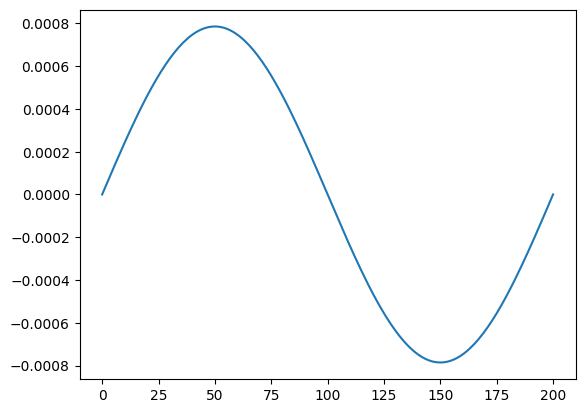

In [4]:
# test normalize
from preprocessing.normalize import normalize_data_1d
data = dataset[0]
normed_data = normalize_data_1d(
    data=data,
    x_min=0, x_max=512,
    ea_min=ea_min, ea_max=ea_max,
    p_min=p_min, p_max=p_max,
    u_min=u_min, u_max=u_max
)
print(normed_data)
plt.plot(normed_data.flowrate_bc[1000,:])
plt.show()

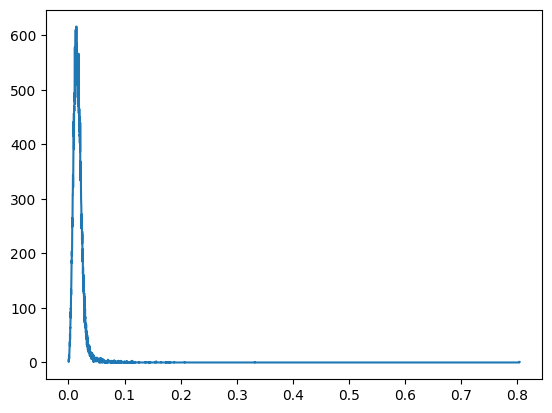

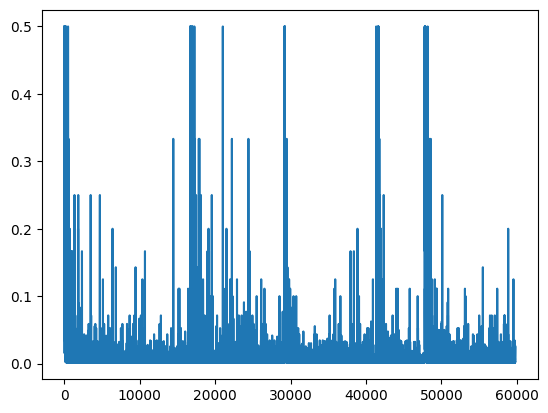

In [63]:
# calculate weighted loss
data = normed_data
diam = data.edge_attr.numpy()[:,0]
length = data.edge_attr.numpy()[:,1]

(count, bins) = np.histogram(diam, bins=5000)
n_edge = diam.shape[0]

# print(count)
# print(bins)

def weight(val : float):
    bin_id = np.where(bins >= val)[0][0] - 1
    weight_mean = 1. / (count[bin_id] + 1e0)
    return weight_mean

v_weight = np.vectorize(weight)
weight_diam = v_weight(diam)


def cal_weight(x : np.array, bins=1000) -> np.array:
    (count, bin) = np.histogram(x, bins=bins)
    N = x.shape[0]

    def _weight(value : float):
        _bin_id = np.where(bin >= value)[0][0] - 1
        _weight = 1. / (count[_bin_id] + 1.)
        return _weight
    
    v_weight = np.vectorize(_weight)

    return v_weight(x)

plt.plot(bins[:-1], count)
plt.show()

plt.plot(weight_diam)
# plt.xlim(21000,21025)
plt.show()